In [1]:
import numpy as np
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask

from ekarus.e2e.pyramid_wfs import PyramidWFS
from ekarus.e2e.utils.create_field_from_zernike_coefficients import create_field_from_zernike_coefficients

In [41]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= np.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/np.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

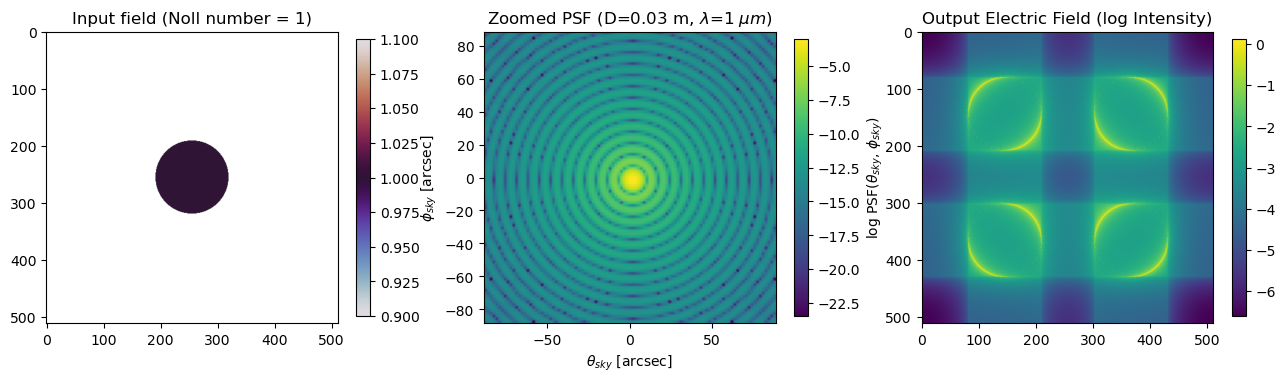

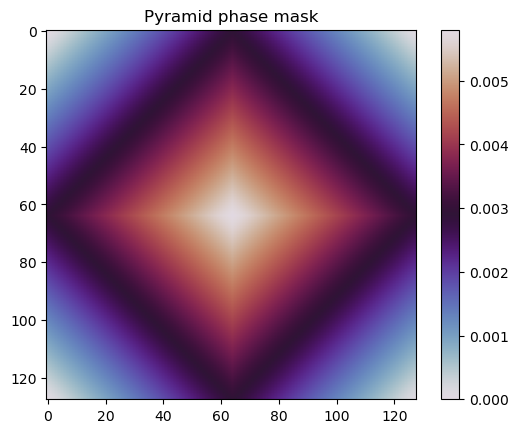

In [42]:
nx = 128

# Create pupil mask
oversampling = 4
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

# Conversions
pupilDiameterInM = 30e-3
lambdaInM = 1000e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 1
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

# Inizializzazione del sensore
apex_angle = 0.0058 # vertex angle in radians, can be tricky to find the right value
wfs = PyramidWFS(apex_angle/pix2rad)

# Propagazione del campo attraverso il sensore
output_field = wfs.propagate(input_field)
intensity = np.abs(output_field**2)

# Compute normalized psf
psf = np.abs(wfs.field_on_focal_plane**2)
psf *= 1/np.sum(psf)


# Plotting results
s = 0.45
plt.figure(1, figsize=(16,8))
plt.subplot(1, 3, 1)
plt.title(f'Input field (Noll number = {noll})')
plt.imshow(np.angle(input_field), cmap='twilight')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
showZoomCenter(psf, pix2arcsec, title=r'Zoomed PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\theta_{sky}$ [arcsec]', ylabel=r'$\phi_{sky}$ [arcsec]',
               zlabel=r'log PSF($\theta_{sky}$, $\phi_{sky}$)', shrink=0.45)
# plt.title("PSF on Focal Plane (Intensity) - Log Scale")
# plt.imshow(np.log( psf ), cmap='inferno')
# plt.colorbar(shrink=s)

plt.subplot(1, 3, 3)
plt.title("Output Electric Field (log Intensity)")
plt.imshow(np.log(intensity))
plt.colorbar(shrink=s)
plt.show()

plt.figure(2)
plt.imshow(wfs.pyramid_phase_delay((nx, nx))*pix2rad, cmap='twilight')
plt.title("Pyramid phase mask")
plt.colorbar()
plt.show()

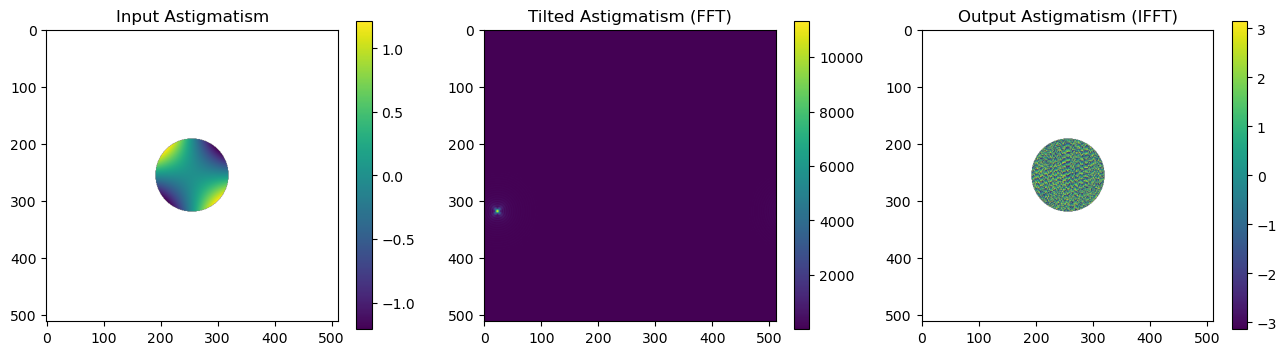

In [ ]:
def generate_tilt(shape, alpha):
    ny, nx = shape
    cx, cy = nx // 2, ny // 2

    # Coordinates wrt center
    x = np.arange(nx) - cx
    y = np.arange(ny) - cy
    tiltX, tiltY = np.meshgrid(x, y)

    # tiltX = X/np.max(X)
    # tiltY = Y/np.max(Y) 

    tilt = tiltX * np.cos(alpha) + tiltY * np.sin(alpha)
    #norm_tilt = (tilt-np.mean(tilt))/np.std(tilt)

    return tilt

shape = np.shape(output_field)

diameter = 30e-3
alpha = 3*lambdaInM/diameter
angle = np.pi*0.2

# plt.figure()
tt = generate_tilt(shape,angle)*alpha/pix2rad
# plt.imshow(tt)
# plt.colorbar()

nx, ny = np.shape(intensity)

nx = 128
oversampling = 4
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)
input_astigmatism = create_field_from_zernike_coefficients(mask, 5, 0.5)
# fft_astigmatism = np.fft.fft2(input_astigmatism)
# fft_astigmatism = np.fft.fftshift(fft_astigmatism)

fft_tilted_astigmatism = np.fft.fftshift(np.fft.fft2(input_astigmatism*np.exp(1j*tt)))
tilted_astigmatism = np.fft.ifft2(np.fft.ifftshift(fft_tilted_astigmatism))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.title("Input Astigmatism")
plt.imshow(np.angle(input_astigmatism))
plt.colorbar(shrink=0.5)

plt.subplot(1, 3, 2)
plt.title("Tilted Astigmatism (FFT)")
plt.imshow(np.abs(fft_tilted_astigmatism))
plt.colorbar(shrink=0.5)

img = np.ma.masked_array(np.angle(tilted_astigmatism), mask=mask.mask())
plt.subplot(1, 3, 3)
plt.title("Output Astigmatism (IFFT)")
plt.imshow(img)
plt.colorbar(shrink=0.5)

(240.0, 272.0)

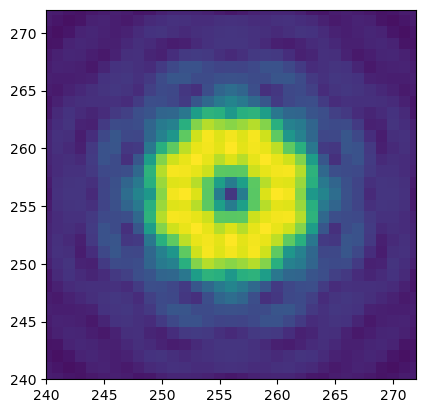

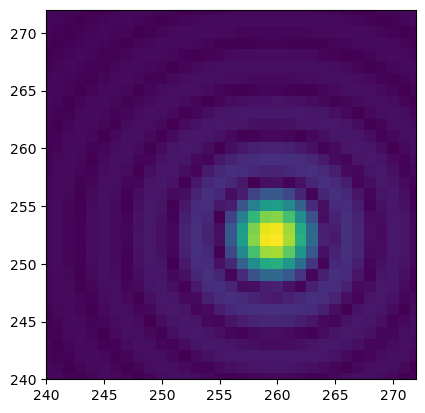

In [77]:
N_steps = 8
alpha = 4*lambdaInM/diameter

# test modulation
ny, nx = np.shape(input_field)
cx, cy = nx // 2, ny // 2

# Coordinates wrt center
x = np.arange(nx) - cx
y = np.arange(ny) - cy

# Tilt coordinates
X,Y = np.meshgrid(x, y)
tiltX = X#/np.max(np.abs(X))
tiltY = Y#/np.max(np.abs(Y))

# Number of steps for modulation (multiple of 4 for symmetry between subapertures)
phi_vec = 2*np.pi*np.arange(N_steps)/N_steps

# Initialize intensity and perform modulation
intensity = np.zeros([ny,nx])
pow_psf = np.zeros([ny,nx])

for phi in phi_vec:
    tilt = tiltX * np.cos(phi) + tiltY * np.sin(phi)
    tilt *= 1/np.sqrt((np.max(X)*np.cos(phi))**2 + (np.max(Y)*np.sin(phi))**2)
    tilted_input = input_field * np.exp(1j*tilt*alpha/pix2rad)

    psf = np.fft.fftshift(np.fft.fft2(tilted_input))
    pow_psf += np.abs(psf)

    output = wfs.propagate(tilted_input)
    intensity += (np.abs(output)**2)/N_steps


plt.figure()
plt.imshow(pow_psf)
plt.xlim([240,272])
plt.ylim([240,272])


plt.figure()
plt.imshow(np.abs(psf))
plt.xlim([240,272])
plt.ylim([240,272])

In [74]:
print(phi_vec)

[0.         0.78539816 1.57079633 2.35619449 3.14159265 3.92699082
 4.71238898 5.49778714]


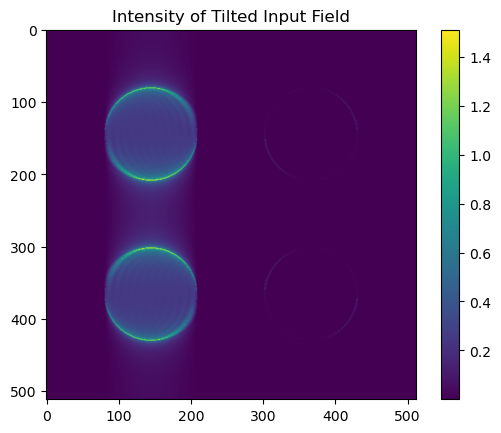

In [21]:
tilted_input = input_field *np.exp(1j*tt)
output_field = wfs.propagate(tilted_input)

# wfs_mod = PyramidWFS(apex_angle)
# output_field = wfs_mod.propagate(input_field)
# wfs_mod._ef_focal_plane_delayed *= np.exp(1j*tt)
# output_field = np.fft.ifft2(wfs_mod._ef_focal_plane_delayed, norm = 'ortho')

I = np.abs(output_field**2)

plt.figure()
plt.title("Intensity of Tilted Input Field")
plt.imshow(I)
plt.colorbar()
plt.show()


In [6]:
# diameter = 0.03
# alpha = 3*lambdaInM/diameter

# pix_radius = alpha/pix2arcsec*rad2arcsec

# nx, ny = np.shape(intensity)
# cx, cy = nx // 2, ny // 2

# ring = np.fromfunction(lambda x,y: np.abs(np.sqrt((x-cx)**2+(y-cy)**2)-pix_radius)<0.4,(nx,ny))

# plt.figure()
# plt.imshow(ring)
# plt.xlim([cx-20,cx+20])
# plt.ylim([cy-20,cy+20])

# fft_ring = np.fft.fft2(ring,norm = 'ortho')
# fft_ring = np.fft.fftshift(fft_ring)

# plt.figure()
# plt.imshow(np.abs(fft_ring))
# plt.colorbar()  
# plt.title("FFT of the ring")

# fft_input = np.fft.fft2(input_field, norm ='ortho')
# fft_input = np.fft.fftshift(fft_input)

# fft_conv = fft_input * fft_ring

# amplitude = np.abs(fft_conv)
# phase = np.angle(fft_conv) + wfs.pyramid_phase_delay((nx, ny))
# delayed_fft_conv = amplitude * np.exp(1j * phase)

# delayed_fft_conv = np.fft.ifftshift(delayed_fft_conv)
# output_field = np.fft.ifft2(delayed_fft_conv, norm='ortho')

# plt.figure()
# plt.imshow(np.abs(output_field)**2)
# plt.colorbar()


In [7]:
# nx = 128

# # Create pupil mask
# oversampling = 4
# mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)
# pupil = mask.mask()

# fft_pupil = np.fft.fft2(pupil,norm='ortho')
# fft_pupil = np.fft.fftshift(fft_pupil)
# delayed_fft_pupil = fft_pupil * np.exp(1j*wfs.pyramid_phase_delay(np.shape(fft_pupil)))
# out_field = np.fft.ifftshift(delayed_fft_pupil)
# out_field = np.fft.ifft2(out_field)

# out_int = (np.abs(out_field))**2

# OTF = np.fft.fft2(out_int)

# IntV = OTF * fft_ring

# Int = np.fft.ifftshift(IntV)
# Int = np.fft.ifft2(Int)

# plt.figure()
# plt.imshow(np.abs(Int))

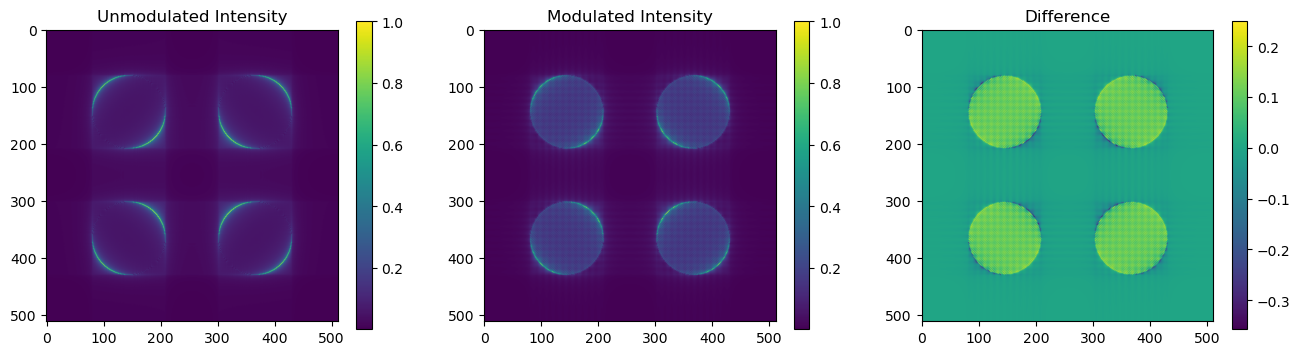

In [22]:
def modulate(input, alpha_pix):
    ny, nx = np.shape(input)
    cx, cy = nx // 2, ny // 2

    # Coordinates wrt center
    x = np.arange(nx) - cx
    y = np.arange(ny) - cy

    # X, Y = np.meshgrid(x, y)
    # tiltX = X/np.max(X)
    # tiltY = Y/np.max(Y) 
    tiltX, tiltY = np.meshgrid(x, y)

    intensity = np.zeros([ny,nx])

    N_steps = int((alpha_pix//4+1)*4)

    for i in range(N_steps):
        phi = np.pi*2/N_steps*i
        tilt = tiltX * np.cos(phi) + tiltY * np.sin(phi)
        # tilt = (tilt-np.mean(tilt))/np.std(tilt)
        tilted_input = input + np.exp(1j*tilt*alpha_pix)
        output = wfs.propagate(tilted_input)
        intensity += np.abs(output**2)/N_steps

    return intensity

diameter = 0.03
alpha = 3*lambdaInM/diameter
alpha_pix = alpha/pix2rad

modulated_intensity = modulate(input_field, alpha_pix)


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title("Unmodulated Intensity")
plt.imshow(intensity/np.max(intensity))
plt.colorbar(shrink=0.5)


plt.subplot(1,3,2)
plt.title("Modulated Intensity")
plt.imshow(modulated_intensity/np.max(modulated_intensity))
plt.colorbar(shrink=0.5)

plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(modulated_intensity/np.max(modulated_intensity)-intensity/np.max(intensity))
plt.colorbar(shrink=0.5)


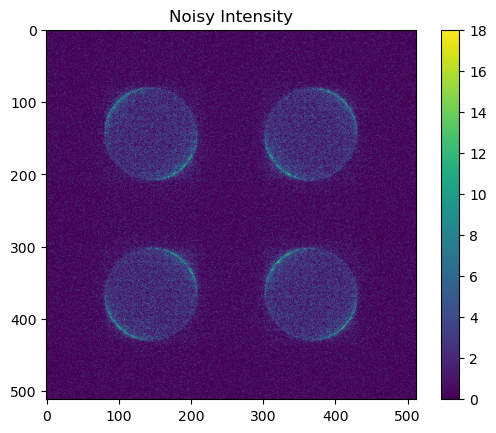

In [27]:
def detector_noise(intensity, flux, RON):
    """
    Simulate detector noise based on the given intensity, flux, and readout noise (RON).
    
    Parameters:
    - intensity: 2D array of intensity values.
    - flux: Real photon flux in the image.
    - RON: Readout noise standard deviation in electrons.
    
    Returns:
    - Noisy intensity image.
    """
    # Re-scale the intensity based on the flux
    norm_intensity = intensity*flux/np.sum(intensity)

    # Add readout noise
    readout_noise = np.random.normal(0, RON, size=np.shape(intensity))

    # Poisson noise based on the intensity
    poisson_noise = np.random.poisson(norm_intensity, np.shape(intensity))

    noisy_intensity = norm_intensity + readout_noise + poisson_noise
    
    return np.maximum(0,np.round(noisy_intensity))

flux = 1e5  # Example flux in photons
RON = 1  # Example readout noise in electrons
noisy_intensity = detector_noise(modulated_intensity, flux, RON)

plt.figure()
plt.title("Noisy Intensity")
plt.imshow(noisy_intensity)
plt.colorbar()

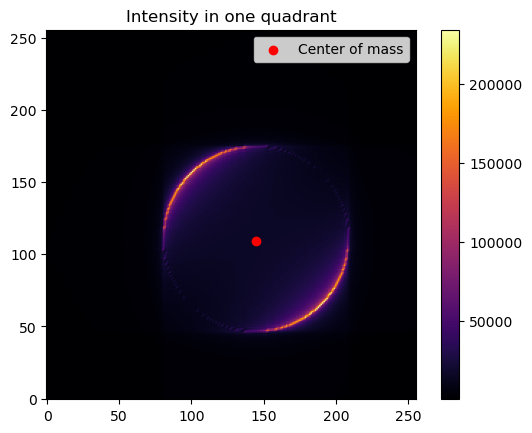

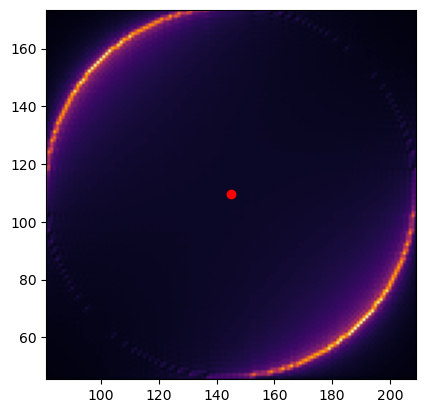

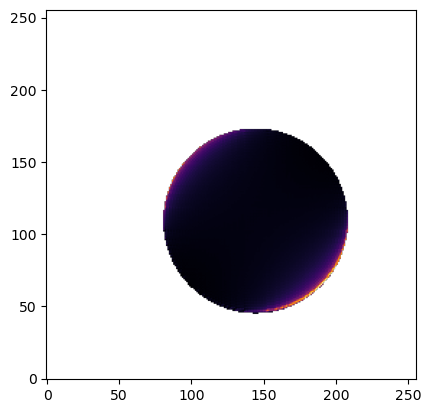

In [10]:
# Find subaperture centers
ny, nx = np.shape(intensity)
cx, cy = nx // 2, ny // 2

# Coordinates wrt center
x = np.arange(nx) - cx
y = np.arange(ny) - cy
X, Y = np.meshgrid(x, y)

quarter_img = modulated_intensity[np.logical_and(X < 0, Y >= 0)]
quarter_img = quarter_img.reshape((ny // 2, nx // 2))

mean_intensity = np.mean(modulated_intensity)

plt.figure()
plt.imshow(quarter_img, cmap='inferno', origin='lower')
plt.title("Intensity in one quadrant")
plt.colorbar()

xquarter = np.arange(nx//2)
yquarter = np.arange(ny//2)
Xquarter, Yquarter = np.meshgrid(xquarter, yquarter)

cy = np.sum(Yquarter * quarter_img) / np.sum(quarter_img)
cx = np.sum(Xquarter * quarter_img) / np.sum(quarter_img)

delta = 0
cy -= delta
cx += delta

plt.scatter(cx, cy, color='red', label='Center of mass')
plt.legend()

Npix = 128
plt.figure()
plt.imshow(quarter_img, cmap='inferno')
plt.scatter(cx, cy, color='red', label='Center of mass')
plt.xlim([cx-Npix//2, cx+Npix//2])
plt.ylim([cy-Npix//2, cy+Npix//2])

mask = CircularMask(np.shape(quarter_img), maskRadius=Npix//2, maskCenter=(cy,cx))
cmask = mask.mask()
masked_int = np.ma.masked_array(quarter_img, mask=cmask)

plt.figure()
plt.imshow(masked_int,origin='lower',cmap='inferno')

In [11]:
# from scipy.optimize import minimize

# def get_masked_intensity(pars, img):
#     cx,cy = pars
#     mask = CircularMask(np.shape(img), maskRadius=Npix//2, maskCenter=(cy,cx))
#     cmask = mask.mask()
#     masked_data = img[~cmask]
#     masked_intensity = np.sum(masked_data)
#     return -masked_intensity

# opt = minimize(get_masked_intensity, (cx,cy), args=quarter_img, bounds = [(0,2*Npix),(0,2*Npix)])


# cy_opt = int(np.round(opt.x[0]))
# cx_opt = int(np.round(opt.x[1]))

# print(cy_opt,cx_opt)
# print(cx,cy)

Text(0.5, 1.0, 'Masked Intensity D')

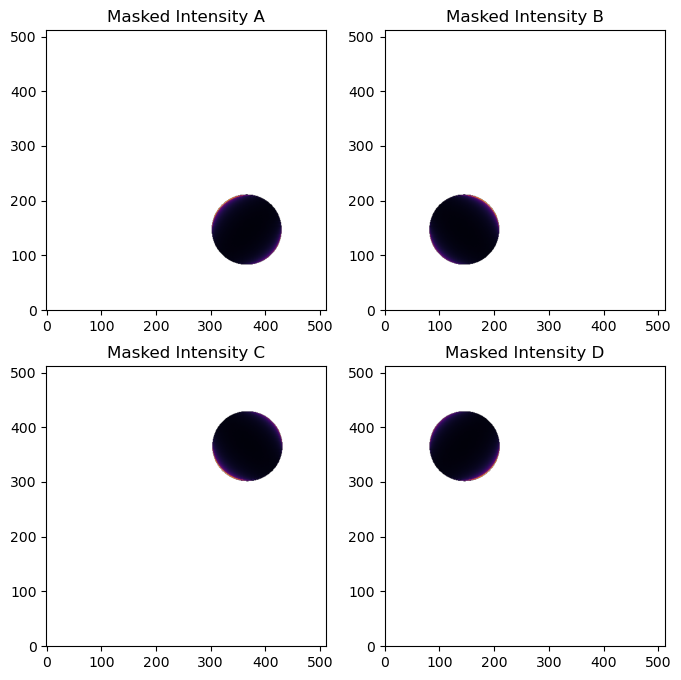

In [12]:
padded_mask = np.ones(np.size(intensity))
padded_mask[np.logical_and(X.flatten() < 0, Y.flatten() >= 0)] = cmask.flatten()
padded_mask = padded_mask.reshape(intensity.shape)          
padded_mask = (padded_mask).astype(bool)

# padded_mask = np.ones_like(intensity)
# padded_mask[np.logical_and(X < 0, Y >= 0)] = cmask

masked_intensity = np.ma.masked_array(intensity, mask=padded_mask)

mask_D = padded_mask.copy()
mask_B = np.flip(mask_D, axis = 0)
mask_C = np.flip(mask_D, axis = 1)
mask_A = np.flip(mask_B, axis = 1)


plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(np.ma.masked_array(intensity, mask=mask_A), origin='lower', cmap='inferno')
plt.title("Masked Intensity A")

plt.subplot(2, 2, 2)
plt.imshow(np.ma.masked_array(intensity, mask=mask_B), origin='lower', cmap='inferno')
plt.title("Masked Intensity B")

plt.subplot(2, 2, 3)
plt.imshow(np.ma.masked_array(intensity, mask=mask_C), origin='lower', cmap='inferno')
plt.title("Masked Intensity C")

plt.subplot(2, 2, 4)
plt.imshow(np.ma.masked_array(intensity, mask=mask_D), origin='lower', cmap='inferno')
plt.title("Masked Intensity D")


In [13]:
A = modulated_intensity[~mask_A]
B = modulated_intensity[~mask_B]

AB = np.hstack((A, B))  

print("A shape:", A.shape)
print("B shape:", B.shape)
print("AB shape:", AB.shape)

A shape: (12858,)
B shape: (12858,)
AB shape: (25716,)


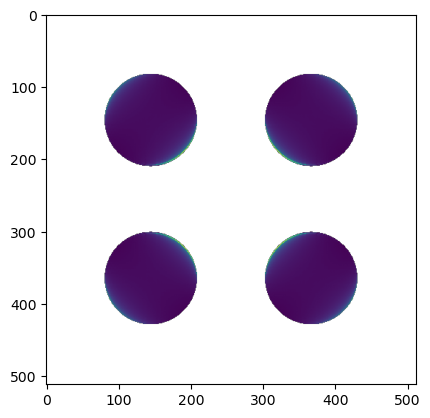

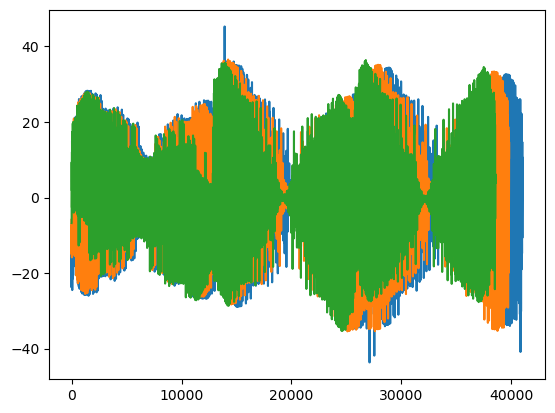

In [14]:
def compute_slopes(intensity, Npix, use_diagonal:bool=False):

    # Find subaperture centers
    ny, nx = np.shape(intensity)
    cx, cy = nx // 2, ny // 2

    # Coordinates wrt center
    x = np.arange(nx) - cx
    y = np.arange(ny) - cy
    X, Y = np.meshgrid(x, y)

    # Use only a single quadrant
    quadrant = intensity[np.logical_and(X < 0, Y >= 0)]
    quadrant = quadrant.reshape((ny // 2, nx // 2))

    # Find photocenter
    xquad = np.arange(nx//2)
    yquad = np.arange(ny//2)
    Xquad, Yquad = np.meshgrid(xquad, yquad)

    cy = np.sum(Yquad * quadrant) / np.sum(quadrant)
    cx = np.sum(Xquad * quadrant) / np.sum(quadrant)

    # Define mask in single quadrant
    # Npix = np.min((nx,ny))//oversampling
    cmask = CircularMask(np.shape(quarter_img), maskRadius=Npix//2, maskCenter=(cy,cx))
    quad_mask = cmask.mask()

    # Pad and flip mask to 4 quadrants
    padded_mask = np.ones(np.size(intensity))
    padded_mask[np.logical_and(X.flatten() < 0, Y.flatten() >= 0)] = quad_mask.flatten()
    padded_mask = (padded_mask.reshape(intensity.shape)).astype(bool)      

    mask_A = padded_mask.copy()
    mask_B = np.flip(mask_A, axis = 1)
    mask_C = np.flip(mask_A, axis = 0)
    mask_D = np.flip(mask_B, axis = 0)

    A = intensity[~mask_A]
    B = intensity[~mask_B]
    C = intensity[~mask_C]
    D = intensity[~mask_D]

    up_down = (A+B) - (C+D)
    left_right = (A+C) - (B+D)

    slope = np.hstack((up_down, left_right))

    if use_diagonal:
        diag = (B+C) - (A+D)
        slope = np.hstack((up_down, left_right, diag))

    # Normalize slopes by the mean intensity
    mean_intensity = np.mean(intensity)
    slope *= 1/mean_intensity

    return slope, mask_A, mask_B, mask_C, mask_D

slopes128, maskA, maskB, maskC, maskD = compute_slopes(modulated_intensity, Npix=128, use_diagonal=True)
slopes130, _, _, _, _ = compute_slopes(modulated_intensity, Npix=130, use_diagonal=True)
slopes132, _, _, _, _  = compute_slopes(modulated_intensity, Npix=132, use_diagonal=True)

full_mask = np.logical_and(mask_A,mask_B)
full_mask = np.logical_and(full_mask,mask_C)
full_mask = np.logical_and(full_mask,mask_D)

plt.figure()
plt.imshow(np.ma.masked_array(modulated_intensity, mask=full_mask))

plt.figure()
plt.plot(slopes132)
plt.plot(slopes130)
plt.plot(slopes128)

Text(0.5, 1.0, 'Masked Intensity D')

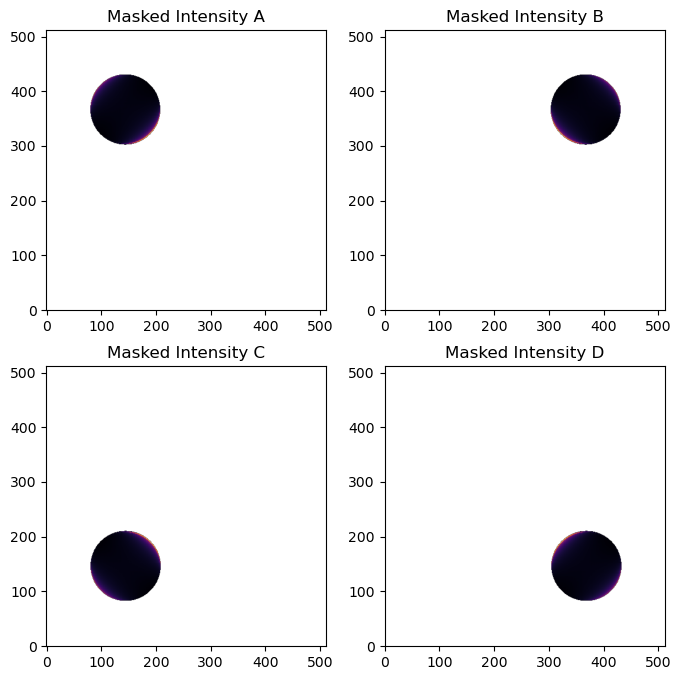

In [15]:
ny,nx = np.shape(modulated_intensity)

subaperture_masks = np.zeros((4, nx, ny), dtype=bool)
subaperture_masks[0] = maskA
subaperture_masks[1] = maskB
subaperture_masks[2] = maskC
subaperture_masks[3] = maskD

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(np.ma.masked_array(modulated_intensity, mask=subaperture_masks[0]),origin='lower', cmap='inferno')
plt.title("Masked Intensity A")
plt.subplot(2, 2, 2)
plt.imshow(np.ma.masked_array(modulated_intensity, mask=subaperture_masks[1]),origin='lower', cmap='inferno')
plt.title("Masked Intensity B")
plt.subplot(2, 2, 3)
plt.imshow(np.ma.masked_array(modulated_intensity, mask=subaperture_masks[2]),origin='lower', cmap='inferno')
plt.title("Masked Intensity C")
plt.subplot(2, 2, 4)
plt.imshow(np.ma.masked_array(modulated_intensity, mask=subaperture_masks[3]),origin='lower', cmap='inferno')
plt.title("Masked Intensity D")